# Tutorial 6
Creating complex models:
* Creating units with multiport inputs.
* Creating new requirements.

## Part 1
### Units with multiport inputs
For some unit models, there may be several types of qualitatively different inputs. An example can be found in the `delta_linear` class of `custom_units.py`. This class, together with the `delta_synapse` class in in `synapses.py` implements a continuous-time version of the _delta_ learning rule.

The _delta_ learning rule is one of the most widespread forms of supervised learning in neural networks. Given a _training set_ consisting of  input vectors 
$(\bf{x_1}, \dots, \bf{x_n})$ and their corresponding desired outptus $(y_1, \dots, y_n)$, the purpose of the delta rule is to adjust the input weights of a unit so
the response to $\bf{x_i}$ is $y_i$. Without going into details, this can sometimes be achieved by presenting the inputs one by one, each time adjusting the weights using:

$\Delta \omega_{j} = \alpha (y - u)x_j$,

where $y$ is the desired response to the input, $u$ is the actual response, $x_j$ is the $j$-th component of the input vector, $\omega_j$ is the corresponding weight, and $\alpha$ is a learning rate.  
To implement this, we require to know not only the input to the unit, but also the desired output. Since the error $e \equiv y - u$ is used by every synapse,
it is computationally efficient to calculate it once in the unit class and make it available to all synapses. Thus, the error is a synaptic _requirement_ that must be updated at every simulation step.

This tutorial is a guide to the source code in the `delta_linear`, and `delta_synapse` classes, which illustrate the tools used
to create units with multiple input ports, and synapses that use custom requirements.

In [1]:
# We can begin by looking at the docstring of the two classes
from draculab import *
help(delta_linear)

Help on class delta_linear in module custom_units:

class delta_linear(units.unit)
 |  A linear unit that modifies its weights using a continuous version of the delta rule.
 |  
 |  This unit scales its input vector so it has a unit L2 norm. Moreover, there is an implicit bias
 |  input that is always 1, and whose weight starts at 0 and changes with rate 'bias_lrate'.
 |  
 |  Units in this class have 3 input ports. 
 |  Port 0 is for the plastic synapses, which are of the delta_synapse class.
 |  Port 1 is for the desired value signal, which is used to produce the error.
 |  Port 2 is for the signal that indicates when to update the synaptic weights.
 |  
 |  The weight of the bias input is updated by the unit, whereas the weights of all inputs
 |  at port 0 are updated by their respective synapses, which must be of the 'delta' type.
 |  These synapses update their weight using: w' = alpha * error * pre, where alpha controls
 |  the learning rate, error is the scaled input sum at port

In [ ]:
help(delta_synapse)

## Part 2
### The ei_net class
Now we will create a delta unit and test it using random input vectors with unit norm.
The desired output will be the norm of the projection of the input vector with a given vector $\bf{v}$.
If the learning algorithm works, the weight vector of the delta unit must approach $\bf{v}$.

To create this simulation we use the `ei_net` class from `ei_net.py`.  
This class is used to run simulations involving three different populations, called **e**, **i**, and **x**.  
These three populations are meant to contain excitatory, inhibitory, and source units respectively. An instance of the `ei_net` class contains default parameter dictionaries for the three populations, and for their connections. In theory we could just create an instance of `ei_net`, run `ei_net.build`, and then start running simulations with `ei_net.run`. Of course, those simulations would not use the network we want to simulate, so we need to adapt the parameters of `ei_net` for this end.

We want the **e** population to contain a single `delta_linear` unit, the **i** population to be empty, and the **x** population to contain __inp_dim__ source units, where __inp_dim__ stands for the dimensionality of the input vectors. Moreover, we want to provide our `delta_linear` unit with the desired output for each input, and with the signal that triggers learning.

This part of the tutorial shows how to configure `ei_net` for this end. Given the multiple input dimensionality of the `delta_linear` unit, the `ei_network` class would be a better tool, but for the purpose of this demonstration `ei_net` is appropriate.

In [1]:
from ei_net import *
help(ei_net)
# ei_net contains many methods. 
# It is not necessary to read all this documentation.

Help on class ei_net in module ei_net:

class ei_net(builtins.object)
 |  This class is used to create, simulate, and visualize a generic network containing 3
 |  populations: excitatory (e), inhibitory (i), and input (x).  The three populations are 
 |  arranged in a rectangular grid. 
 |  
 |  After creating an instance of the ei_net class, the parameters of the network can be
 |  configured by changing the entries of the parameter dictionaries using the ei_net.set_param 
 |  method. Once the parameter dictionaries are as desired the network is created by running
 |  ei_net.build() . All units and connections are created using the topology module.
 |  
 |  An additional 'w_track' population of source units may also be created in order to
 |  track the temporal evolution of a random sample of synaptic weights.
 |  Similarly, 'sc_track' or 'thr_track' populations may be created in order to track
 |  the the values of some scale factors (when using exp_dist_sig units) or thresholds
 |  

The first step will be to configure the inputs.  
the `ei_net.run` method is used to run simulations where a different input pattern is presented to the **e** and **i** populations
every `pres_time` time units. This is reminiscent of how discrete inputs are presented to artificial neural networks, although in this case the inputs are continuous in time.

Two arguments tell `ei_net.run` how to present inputs: `set_inp_pat`, and `set_inp_fun`. `set_inp_pat` is a function that receives a presentation number, and returns its corresponding input pattern. The input patterns, however, are discrete, and still need to be converted into functions of time. This is the role of `set_inp_fun`, which sets the functions of the source units in the **x** population.

`ei_net.run` works using a _for_ cycle, where at each loop a new pattern is selected using `set_inp_pat`, and this pattern is set into the **x** population using `set_inp_fun`. Then the simulation is advanced `pres_time` time units.

`set_inp_fun` can be used to provide continuous transitions between patterns (e.g. the input signals have no "jumps"), and if desired, it can also be used to add noise into the patterns. There is a default version of `set_inp_fun` that is used when this argument is not provided to `ei_net.run`. The default version of `set_inp_fun`, uses linear interpolation to transition between different values of the patterns during the first fifth of the presentation. We will use this.

In [2]:
# A bit more detail can be seen in the documentation
help(ei_net.run)

Help on function run in module ei_net:

run(self, n_pres, pres_time, set_inp_pat=None, set_inp_fun=None)
    Run a simulation, presenting n_pres patterns, each lasting pres_time. 
    
    n_pres : number of pattern presentations to simulate.
    pres_time : time that each pattern presentation will last.
    
    At the beginning of each presentation, the method set_inp_pat is called. This creates a new
    pattern to be presented. Then the set_inp_fun method is called, which sets the functions
    of the input units based on the new pattern.
    
    set_inp_pat(pres, rows, columns)
        # Given a presentation number and the number of rows and columns in the input layer, 
        # returns an input pattern, which is a 1-D numpy array with the value that the input 
        # function should attain during the presentation.
        # To map a given pair (r,c) to its corresponding entry in the returned vector use:
        # idx = rows*c + r, 
        # e.g. input[idx] corresponds to th

In [2]:
# The first thing we may do is to create the inputs
import numpy as np
# Create the input vectorsgt
inp_dim = 10  # dimensionality of the input vectors
n_inp = 300  # number of input vectors
inps = np.zeros((inp_dim, n_inp)) # each column is an input
for col in range(n_inp):
    vec = np.random.uniform(0., 1., inp_dim)
    inps[:, col] = vec / np.linalg.norm(vec)
    
# Create the desired outputs
v = np.zeros(inp_dim)
v[0::2] = 1. # every other entry is non-zero
v = v / np.linalg.norm(v)
des_out = np.zeros(n_inp)
for idx in range(n_inp):
    des_out[idx] = np.dot(v, inps[:, idx])

# Creating the set_inp_pat argument to ei_net.run
def inp_pat(pres, rows, columns):
    """ The set_inp_pat argument to ei_net.run .
    
        The rows and columns arguments are not used for this case.
        We use the 'inps' and 'des_out' arrays created above.
    """
    return np.concatenate((inps[:, pres%n_inp], [des_out[pres%n_inp], 1.])) 

In the `set_inp_pat` function above it can be seen that in addition to the units with the input pattern, there will be two other input units in **x**, one providing the desired output, and another one the learning trigger signal (always 1).  

We must be careful when specifying the input ports to our `delta_linear` unit. The `ei_net` class connects populations using the `topology.topo_connect` method, which specifies input ports using the `inp_ports` entry of its `syn_spec` dictionary. In `ei_net`
the `syn_spec` dictionary for the **x** to **e** connection is in the `xe_syn` dictionary.

Creation of the **e**, **i**, and **x** populations is done with the `topology.create_group` method, which requires geometry and parameter dictionaries. the `*_geom` and `*_pars` dictionaries (* = e, i, or x) provide the corresponding entries in `ei_net`.

Configuration of the parameter dictionaries in `ei_net` is done with the `set_param` method. The advantage of using this method over directly modifying the dictionaries is that the changes done with `set_param` automatically get logged into a `history` list, which records all the modifications done to the standard parameters. Moreover, `set_param` ensures that no parameter modifications are done after the `ei_net.build` method has been called.

In [ ]:
help(ei_net.set_param)

In [ ]:
help(ei_net.__init__)

In [3]:
## Create an instance of ei_net
one_delta = ei_net()

## Specify the number of units in e, i, and x
# One single unit in e
one_delta.set_param('e_geom', 'rows', 1)
one_delta.set_param('e_geom', 'columns', 1)
one_delta.set_param('e_geom', 'center', [1., 0.])
# No units in i
one_delta.set_param('i_geom', 'rows', 0)
one_delta.set_param('i_geom', 'center', [1., 0.])
# inp_dim+2 units in x
one_delta.set_param('x_geom', 'rows', inp_dim+2)
one_delta.set_param('x_geom', 'columns', 1)

## configure the xi connection
one_delta.set_param('xe_syn', 'type', synapse_types.delta)
one_delta.set_param('xe_syn', 'lrate', 0.4)
one_delta.set_param('xe_syn', 'inp_ports', [0]*inp_dim + [1,2])
one_delta.set_param('xe_conn', 'mask', {'circular': {'radius':10}})

## configure the delta unit
one_delta.set_param('e_pars', 'type', unit_types.delta_linear)
one_delta.set_param('e_pars', 'gain', 1.)
one_delta.set_param('e_pars', 'tau_min', 0.02 )
one_delta.set_param('e_pars', 'tau_wid', 0.)
one_delta.set_param('e_pars', 'tau_e', 1.)
one_delta.set_param('e_pars', 'bias_lrate', 0.01)
one_delta.set_param('e_pars', 'n_ports', 3)

The `center` entry of the `e_geom` dictionary specifies the center of the rectangular grid where the units will be placed.
The location of the units affects not only how they are visualized, but also the delay between the connections.

Another thing to observe is how the input ports of the "xe" connection are specified using a single list with `inp_dim` zeros and a `[1,2]` appended at the end. This is not a good general way to set the input ports, since it is harder to read, and the length of the list must match the number of connections being made, which is tricky when using random connectivity. In general, it is better to use `ei_network` when setting multiport connections, using separate layers for all the unit groups that target a specific port.

Finally, notice that when configuring the delta unit we did not set the value of the `tau` parameter directly, but instead `tau_min` and `tau_wid`. The `tau` parameter of the units created by `ei_net.build` is set stochastically using a uniform distribution ranging from `tau_min` to `tau_min` + `tau_wid`. This approach is used for setting the `slope`, `thresh`, `tau`, and `init_val` parameters.

### Exercise 1
What is wrong with the configuration of the xi synapses?

As can be seen, all the synapses in the the xi connection use `delta` synapses. 
This is not appropriate for the inputs to ports 1 and 2. Unlike the `inp_ports` entry, we can't use a list to specify the synapse types.
A fix to this is to set `lrate`=0 for these two synapses. Unfortunately, `lrate` also can't be set with multiple values on a list.
Thus we are pushed to do something "bad". We will build the `ei_net` object, and then we will set the learning rates to zero.

Changing parameters after building has to be done directly in the synapse object, rather than on the dictionaries of `ei_net`.
Such changes are not automatically logged, and can hurt reproducibility of the results, but the user can do as she pleases.

This problem is simple to avoid using the `ei_network` class, but this case is more illustrative.

In [4]:
## build the ei_net object
one_delta.build()

## locate the synapses to ports 1 and 2, and freeze them
for syn_list in one_delta.net.syns:
    for syn in syn_list:
        if syn.port == 1 or syn.port == 2:
            syn.w = 1.
            syn.lrate = 0.
            syn.alpha = 0.
            # alpha = min_delay * lrate. 
            # It is used instead of lrate in the update function

/home/z/projects/draculab/topology.py:286: UserWarning: topo_connect received an empty list as an argument
  warn('topo_connect received an empty list as an argument', UserWarning)


In [7]:
# before simulating we can have a quick look at how the connection weights
# The input units are on the left, and the delta unit is on the right.
# The radius and color of the circles indicate the initial strength of the connection.
help(one_delta.conn_anim)
one_delta.conn_anim(one_delta.x[0:10], one_delta.e, interv=200, slider=False, weights=True)

Help on method conn_anim in module ei_net:

conn_anim(source, sink, interv=100, slider=False, weights=True) method of ei_net.ei_net instance
    An animation to visualize the connectivity of populations. 
    
    source and sink are lists with the IDs of the units whose connections we'll visualize. 
    
    Each frame of the animation shows: for a particular unit in source,
    all the neurons in sink that receive connections from it (left plot), and for 
    a particular unit in sink, all the units in source that send it connections
    (right plot).
    
    interv is the refresh interval (in ms) used by FuncAnimation.
    
    If weights=True, then the dots' size and color will reflect the absolute value
    of the connection weight.
    
    Returns:
        animation object from FuncAnimation if slider = False
        widget object from ipywidgets.interact if slider = True



There should be a warning caused by `topo_connect` receiving an empty list. This is because the **i** population is empty.

Now we can run a simulation.
The results of the simulation will be available in the `all_times` and `all_activs` arrays of the `ei_net` object.

There are several methods that can be used to visualize the results:
* basic_plot
* conn_anim
* act_anim
* hist_anim
* double_anim

In [12]:
# First a short simulation, to see what's happening
n_pres = 5 #n_inp # number of input presentations
pres_time = 1. # time duration for each presentation
one_delta.run(n_pres, pres_time, set_inp_pat=inp_pat)
one_delta.basic_plot()

Presentation 0 took 0.11802911758422852 seconds.
Presentation 1 took 0.10223126411437988 seconds.
Presentation 2 took 0.10718774795532227 seconds.
Presentation 3 took 0.1048736572265625 seconds.
Presentation 4 took 0.10324835777282715 seconds.
Total execution time is 0.5366601943969727 seconds


As can be observed, `basic_plot` shows not only the activity of the inputs and the delta unit, but also some synaptic weights,
the 'learning' and 'error' variables of the delta unit. Behind the scenes `ei_net.build` created some source units and set their functions equal to the value of these variables. The number of source units created to track synaptic weights can be set with in the `w_track` entry of the `n` dictionary.

Presentation 0 took 0.1412181854248047 seconds.
Presentation 1 took 0.11076998710632324 seconds.
Presentation 2 took 0.11960530281066895 seconds.
Presentation 3 took 0.11278796195983887 seconds.
Presentation 4 took 0.11350512504577637 seconds.
Presentation 5 took 0.11601781845092773 seconds.
Presentation 6 took 0.11553764343261719 seconds.
Presentation 7 took 0.11043357849121094 seconds.
Presentation 8 took 0.10775089263916016 seconds.
Presentation 9 took 0.11205649375915527 seconds.
Presentation 10 took 0.10863900184631348 seconds.
Presentation 11 took 0.10963225364685059 seconds.
Presentation 12 took 0.10845160484313965 seconds.
Presentation 13 took 0.10961222648620605 seconds.
Presentation 14 took 0.11142253875732422 seconds.
Presentation 15 took 0.11481952667236328 seconds.
Presentation 16 took 0.11446738243103027 seconds.
Presentation 17 took 0.10883760452270508 seconds.
Presentation 18 took 0.11197209358215332 seconds.
Presentation 19 took 0.11272668838500977 seconds.
Presentatio

Presentation 163 took 0.11201763153076172 seconds.
Presentation 164 took 0.10957670211791992 seconds.
Presentation 165 took 0.11761474609375 seconds.
Presentation 166 took 0.11067676544189453 seconds.
Presentation 167 took 0.11542940139770508 seconds.
Presentation 168 took 0.10901212692260742 seconds.
Presentation 169 took 0.11209487915039062 seconds.
Presentation 170 took 0.11301064491271973 seconds.
Presentation 171 took 0.11171126365661621 seconds.
Presentation 172 took 0.10890483856201172 seconds.
Presentation 173 took 0.11505889892578125 seconds.
Presentation 174 took 0.11797690391540527 seconds.
Presentation 175 took 0.11408185958862305 seconds.
Presentation 176 took 0.10971641540527344 seconds.
Presentation 177 took 0.11108851432800293 seconds.
Presentation 178 took 0.10918283462524414 seconds.
Presentation 179 took 0.11078500747680664 seconds.
Presentation 180 took 0.1136479377746582 seconds.
Presentation 181 took 0.11437869071960449 seconds.
Presentation 182 took 0.11455154418

Presentation 324 took 0.11159729957580566 seconds.
Presentation 325 took 0.1096181869506836 seconds.
Presentation 326 took 0.1102290153503418 seconds.
Presentation 327 took 0.11032652854919434 seconds.
Presentation 328 took 0.11121273040771484 seconds.
Presentation 329 took 0.10977339744567871 seconds.
Presentation 330 took 0.11494135856628418 seconds.
Presentation 331 took 0.11291384696960449 seconds.
Presentation 332 took 0.10864877700805664 seconds.
Presentation 333 took 0.11310195922851562 seconds.
Presentation 334 took 0.11264801025390625 seconds.
Presentation 335 took 0.11151766777038574 seconds.
Presentation 336 took 0.11107254028320312 seconds.
Presentation 337 took 0.1162261962890625 seconds.
Presentation 338 took 0.11095118522644043 seconds.
Presentation 339 took 0.1128997802734375 seconds.
Presentation 340 took 0.11209774017333984 seconds.
Presentation 341 took 0.10960721969604492 seconds.
Presentation 342 took 0.11445331573486328 seconds.
Presentation 343 took 0.11981081962

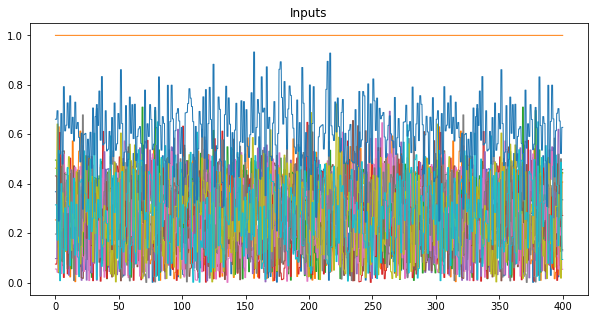

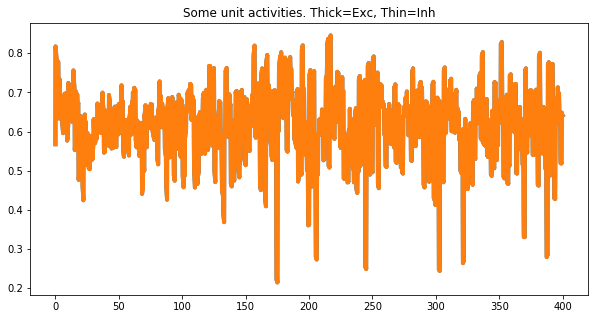

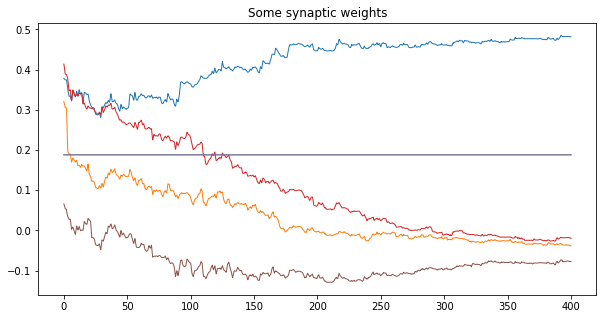

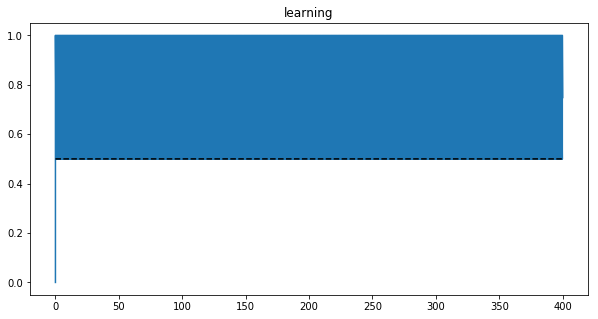

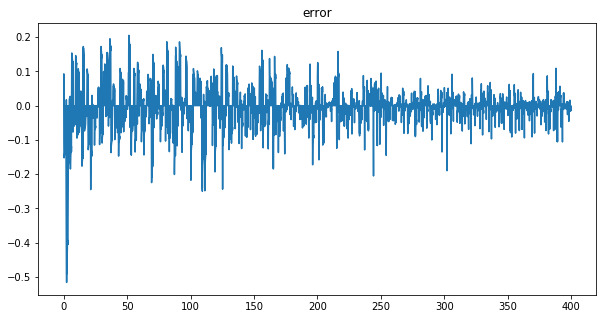

In [5]:
# Now a longer simulation
n_pres = 400 # number of input presentations
pres_time = 1. # time duration for each presentation
one_delta.run(n_pres, pres_time, set_inp_pat=inp_pat)
one_delta.basic_plot()

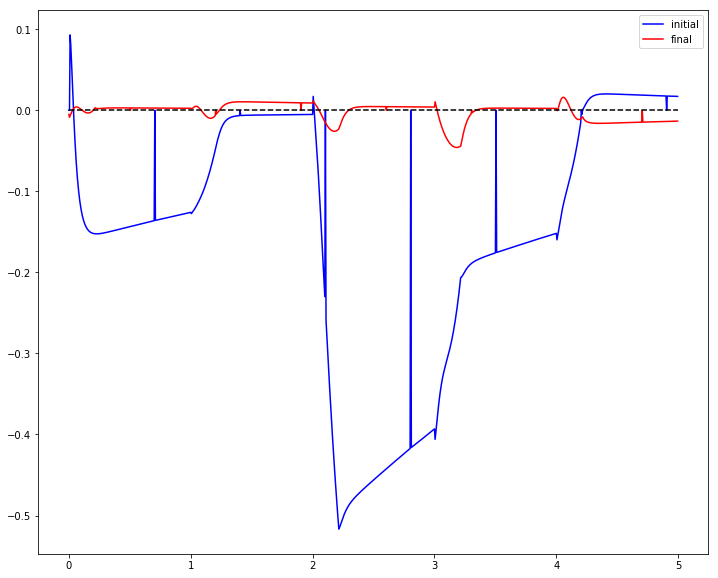

In [6]:
# Now let's see if the learning is working

# First, the error should be converging to zero
# The ei_net object recorded the errors for basic plot.
# They are in the activity of the unit with 'error_track[0]' ID.
err_var = one_delta.all_activs[one_delta.error_track[0]]
# Let's plot the first points of the simulation against the last ones
err_fig = plt.figure(figsize=(12,10))
n_points = 1000  # how many points to plot
ts = one_delta.all_times
ts1 = ts[0:n_points]
err_var1 = err_var[0:n_points]
ts2 = ts[-n_points:] - ts[-n_points] + ts1[0]
err_var2 = err_var[-n_points:]
plt.plot(ts1, err_var1, 'b', label='initial', figure=err_fig)
plt.plot(ts2, err_var2, 'r', label='final', figure=err_fig)
plt.plot(ts1, np.zeros_like(ts1), 'k--', figure=err_fig)
plt.legend()
plt.show()

Notice that after learning the error goes through brief "jumps" and then goes back near zero.
The "jumps" in the error happen when there are transitions between the patterns.  
The `delta_linear` unit does not respond instantaneously; it adjusts its output with a `tau` time constant, and during this adjustment
its output is not as desired.

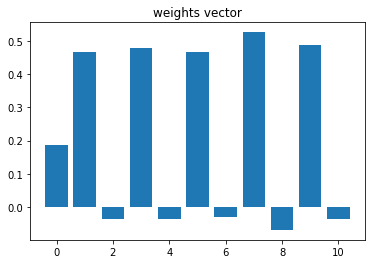

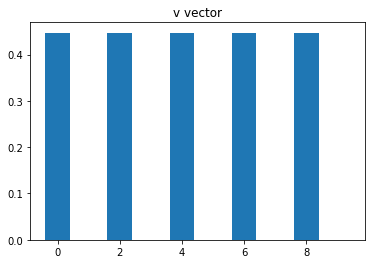

[0.4472136 0.        0.4472136 0.        0.4472136 0.        0.4472136
 0.        0.4472136 0.       ]
[ 0.18785495  0.46699692 -0.03656964  0.47940757 -0.03679402  0.46523854
 -0.02945813  0.52552083 -0.06872254  0.48791426 -0.03473201]


In [8]:
# second, the input weights of the delta unit should resemble the 'v' vector
net = one_delta.net
weights = net.units[one_delta.e[0]].get_mp_weights(net.sim_time)
weights = weights[0] # only weights at port 0
plt.figure()
plt.bar(list(range(len(weights))), weights)
plt.title('weights vector')
plt.figure()
plt.bar(list(range(len(v))), v)
plt.title('v vector')
plt.show()
print(v)
print(weights)

In [12]:
for slist in one_delta.net.syns:
    for syn in slist:
        print("%d --> %d" %(syn.preID, syn.postID))

0 --> 0
1 --> 0
2 --> 0
3 --> 0
4 --> 0
5 --> 0
6 --> 0
7 --> 0
8 --> 0
9 --> 0
10 --> 0
11 --> 0
12 --> 0


In [9]:
one_delta.net.units

In [15]:
a = np.arange(25).reshape(5,5)
b = np.arange(5).reshape(5,1)
print(np.dot(a[:,0],b))
print(a)
print(b)

[150]
[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[[0]
 [1]
 [2]
 [3]
 [4]]


In [16]:
5 + 20 + 45 + 80

150

### Solution to exercise 2.
The "jumps" inthe error happen when there are transitions between the patterns.  
The `delta_linear` unit does not respond instantaneously; it adjusts its output with a `tau` time constant, and during this adjustment
its output is not as desired.

The magnitude of the jumps can be controlled by changing the value of the `tau_min` parameter.